In [1]:
%matplotlib inline
import warnings
import numpy as np
import matplotlib.pyplot as plt
import hera_cal
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
Nants = 37

ants = np.loadtxt('antenna_positions_%d.dat'%Nants)
idxs = np.arange(Nants)
antpos = {}
for k,v in zip(idxs,ants):
    antpos[k] = v
    
redbls = hera_cal.redcal.get_pos_reds(antpos)

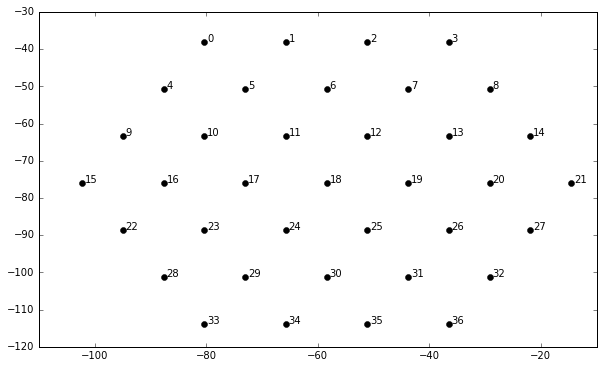

In [3]:
def plot_ants(antpos):
    for k,v in antpos.items():
        plt.plot(v[0],v[1],'ko')
        plt.annotate('%d'%k,xy=(v[0],v[1]),xytext=(v[0]+.5,v[1]))
plot_ants(antpos)

In [4]:
def plot_redbl(redbls):
    for a1,a2 in redbls:
        plt.plot([antpos[a1][0],antpos[a2][0]],[antpos[a1][1],antpos[a2][1]],'k-')

# Minimal unit

The smallest repeating unit that has redundant baselines with number of measurements greater than number of equation is the 7 antenna hexagon.

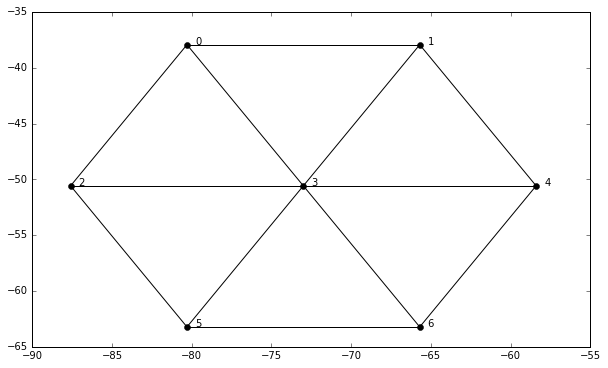

In [5]:
Nants = 7
ants = np.loadtxt('antenna_positions_37.dat')
idxs = np.arange(Nants)
antpos = {}

antpos[0] = ants[0]; antpos[1] = ants[1]
antpos[2] = ants[4]; antpos[3] = ants[5]; antpos[4] = ants[6]
antpos[5] = ants[10]; antpos[6] = ants[11]

plot_ants(antpos)

redbls = hera_cal.redcal.get_pos_reds(antpos)
plot_redbl(redbls[0])
plot_redbl(redbls[1])
plot_redbl(redbls[2])

In [6]:
allbls = [bl for red in redbls for bl in red]
len(allbls)

21

In [7]:
def genA(redbls,basis=None):
    # number of parameters = num_ants + num_unique baselines
    N = Nants + len(redbls)
    
    # number of measurements = total number of baselines
    allbls = [bl for red in redbls for bl in red]
    M = len(allbls)
    
    if basis is None: basis = np.identity(N)
    
    A = np.zeros([M,N],dtype=np.complex)
    i = 0
    for bl,reds in enumerate(redbls):
        for pair in reds:
            A[i,pair[0]] = (1+1j)*basis[pair[0]][pair[0]]
            A[i,pair[1]] = (1-1j)*basis[pair[1]][pair[1]]
            A[i,Nants+bl] = 1+1j
            i += 1
    return np.matrix(A)

In [8]:
A = genA(redbls)
M,N = np.shape(A)
print M,N

21 16


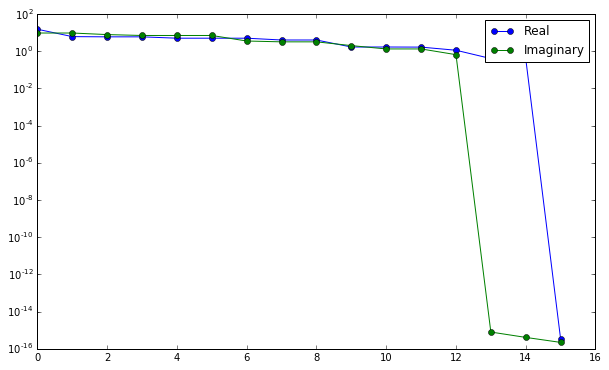

In [9]:
# Find the SVD of the real and imaginary parts of A

Mr = np.dot(np.real(A.T), np.real(A))
Mi = np.dot(np.imag(A.T), np.imag(A))

Ur,Sr,Vr = np.linalg.svd(Mr)
Ui,Si,Vi = np.linalg.svd(Mi)

plt.semilogy(Sr,'o-',label='Real')
plt.semilogy(Si,'o-',label='Imaginary')
plt.legend()
plt.show()

True
False


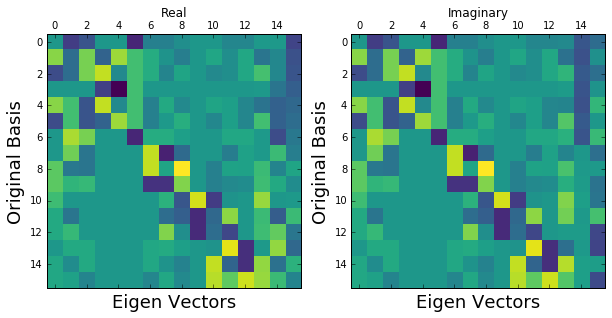

In [10]:
# Compare U and V for the real and imaginary parts.
# Since A.T * A is symmetric, U and V should be equal.
# This is true for the real but not the imaginary??

print np.all(np.isclose(Ur,Vr.T))
print np.all(np.isclose(Ui,Vi.T))

fig,ax = plt.subplots(1,2)

im = ax[0].matshow(np.round(Ui,decimals=2),cmap='viridis')
ax[0].set_title('Real')
ax[0].set_xlabel('Eigen Vectors',fontsize=18)
ax[0].set_ylabel('Original Basis',fontsize=18)

im = ax[1].matshow(np.round(Vi.T,decimals=2),cmap='viridis')
ax[1].set_title('Imaginary')
ax[1].set_xlabel('Eigen Vectors',fontsize=18)
ax[1].set_ylabel('Original Basis',fontsize=18)

# Dimensionality Reduction

Reduce the number of dimensions. There are two independent quantities you want to remove from your analysis:

1. The dengerate space: Take an SVD and retain only the first K eigen vectors and eigen values.
2. The visibility space: Construct a projection matrix using the following theorem: 

## Theorem on Projection Matrices:

The necessary and sufficient condition for a square matrix P of order $n$ to be a projector onto subspace V of dimensionality $r$ (dim(V) = r) is given by: 

$$ P = T \Delta_r T^{-1}$$

where T is any arbitrary non-singular square matrix of order $n$ and 

$$\Delta_r = 
\begin{bmatrix}
    1 & 0 & \dots & 0 & 0 & \dots  & 0 \\
    0 & 1 & \dots & 0 & 0 & \dots  & 0 \\
    \vdots & \vdots & \ddots & \vdots & \vdots & \ddots & \vdots \\
    0 & 0 & \dots & 1 & 0 & \dots  & 0 \\
    0 & 0 & \dots & 0 & 0 & \dots  & 0 \\
    \vdots & \vdots & \ddots & \vdots & \vdots & \ddots & \vdots \\
    0 & 0 & \dots & 0 & 0 & \dots  & 0 
\end{bmatrix} $$

There are $r$ unities on the leading diagonals, $1 \leq r \leq n$.

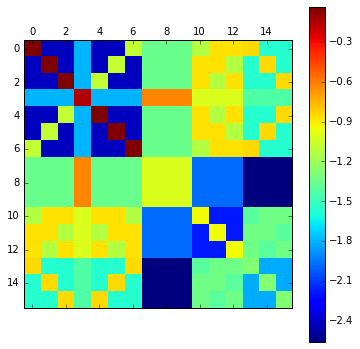

In [18]:
# Original parameter space with 7 ants and 9 visibilities.
del_d = np.identity(N)

# Remove all visibilities except the shortest three baselines.
del_d[Nants:,Nants:] = 0

# Projection matrix in visibility subspace:
Pv = np.einsum('nm,m,pm->np',Ur,np.diag(del_d),Vr.T)

#Pv = del_d

plt.matshow(np.log10(np.abs(Pv)))
plt.colorbar()

## Condition to verify projection matrix:

The necessary and sufficient condition for a square matrix P of order n to be the projection matrix onto V (dim(V) = $r$) is given by:

$$P^2 = P$$

In [42]:
# Check if you have constructed a genuine projection matrix

np.all(np.isclose(np.dot(Pv,Pv),Pv))

True

## Remove degenerate space

Use the same theorem as before, set all zero eigen values to zero.

True
True


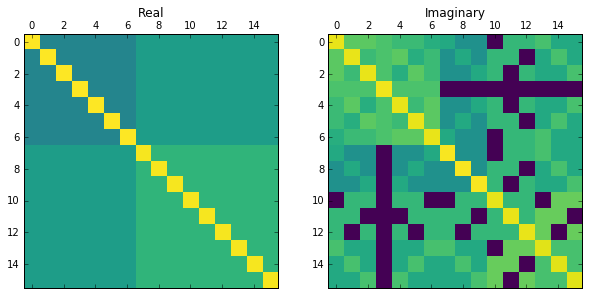

In [12]:
pi_s_real = np.asarray([1 if s>10**-11 else 0 for s in Sr])
pi_s_imag = np.asarray([1 if s>10**-11 else 0 for s in Si])

Pr = np.einsum('nm,m,mp->np',Ur,pi_s_real,Vr)
Pi = np.einsum('nm,m,mp->np',Ui,pi_s_imag,Vi)

#Check that your projection matrix satisfies the necessary and sufficient conditions.
print np.all(np.isclose(np.dot(Pr,Pr), Pr))
print np.all(np.isclose(np.dot(Pi,Pi), Pi))

warnings.filterwarnings('ignore')

fig,ax = plt.subplots(1,2)

im = ax[0].matshow(np.log10(np.abs(Pr)),vmax=0,vmin=-3,cmap='viridis')
ax[0].set_title('Real')

im = ax[1].matshow(np.log10(np.abs(Pi)),vmax=0,vmin=-3,cmap='viridis')
ax[1].set_title('Imaginary')

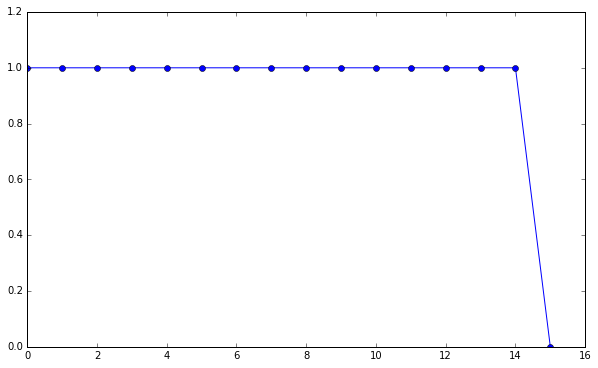

In [13]:
Upr, Spr, Vpr = np.linalg.svd(Pr)

plt.plot(Spr,'o-')

# Combining Projection Matrices

Say a field $F$ is a direct sum of two different subspaces:

$$F = M_1 \oplus N_1 = M_2 \oplus N_2$$

If $P_1$ is a projection onto $M_1$ along $N_1$ and $P_2$ is a projection onto $M_2$ along $N_2$, 

$P = P_1 - P_2$ is a projection if and only if $P_1 P_2 = P_2 P_1 = P_2$.

$P= P_1 - P_2$ is the projection onto $M = M_1 \cap N_2$ along $N = N_1 \oplus M_2$


In our case, $M_1 \equiv g$, $N_2 \equiv N$ (null space), $N_1 \equiv V$ and $M_2 \equiv R$ (row space)

### Understanding the projection matrix built

In our case 

$$P_1 P_2 = P_2 P_1 = P_2$$ 

This makes sense because removing the degenerate space should not cause any changes (our vectors did not lie in that space in the first place). 

That said, I do not understand why $Pv$ and $Pr$ can be constructed the same way, using the same vectors but result in two different subspaces.

In [44]:
print np.all(np.isclose(np.dot(Pv,Pr),Pv))
print np.all(np.isclose(np.dot(Pr,Pv),Pv))

False
False


In [24]:
P = Pr - pi_d
np.all(np.isclose(np.dot(P,P),P))

True

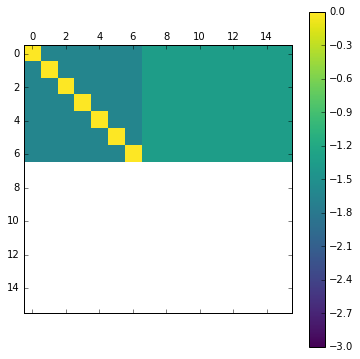

In [51]:
warnings.filterwarnings('ignore')
plt.matshow(np.log10(np.abs(np.dot(Pv,Pr))),vmax=0,vmin=-3,cmap='viridis')
plt.colorbar()

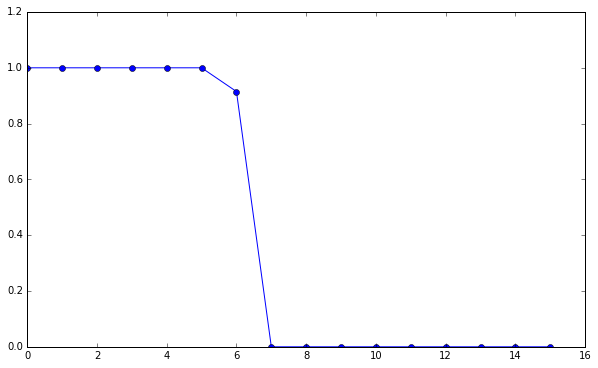

In [54]:
P = np.dot(Pv,Pr)

Up,Sp,Vp = np.linalg.svd(P)

plt.plot(Sp,'o-')

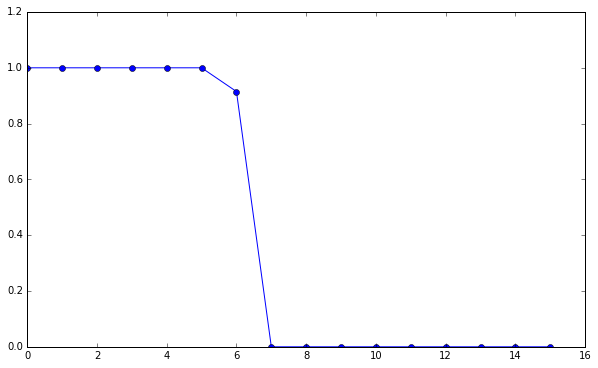

In [14]:
P = np.dot(Pr,Pv)

Up,Sp,Vp = np.linalg.svd(P)

plt.plot(Sp,'o-')

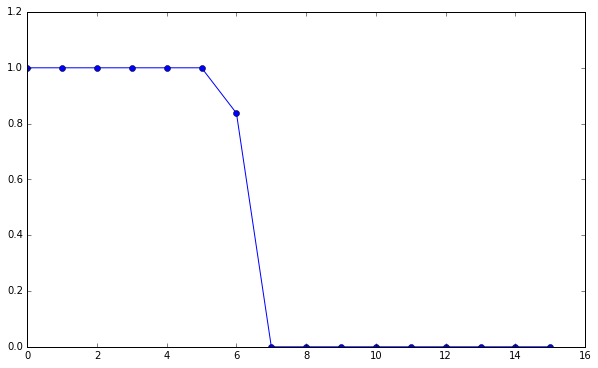

In [59]:
P = np.dot(np.dot(Pr,Pv),Pr)

Up,Sp,Vp = np.linalg.svd(P)

plt.plot(Sp,'o-')

In [58]:
Vp

array([[ 0.        ,  0.47354143, -0.74769614, -0.12410368, -0.02453534,
        -0.02453534,  0.44732908,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.12563672,  0.11147183, -0.07251932,  0.59487688,
        -0.7823852 ,  0.02291909,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        , -0.46428884,  0.18261194, -0.55497456,  0.09190635,
         0.09190635,  0.65283876,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.5387662 ,  0.47802313, -0.31098358, -0.56262888,
        -0.24146047,  0.0982836 ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-0.9258201 ,  0.15430335,  0

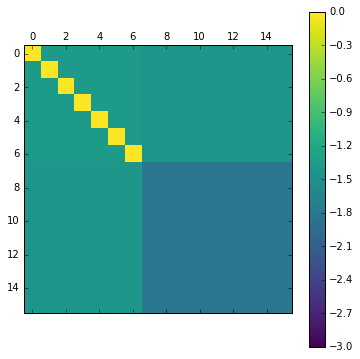

In [49]:
warnings.filterwarnings('ignore')
plt.matshow(np.log10(np.abs(np.dot(np.dot(Pr,Pv),Pr))),vmax=0,vmin=-3,cmap='viridis')
plt.colorbar()

In [32]:
# Final projection matrix
P = np.dot(Pr,Pv)

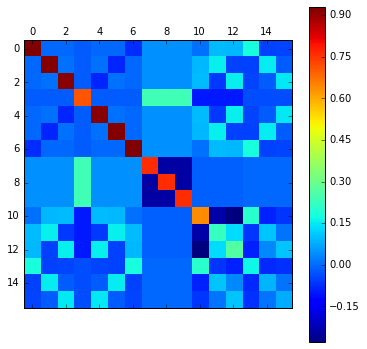

In [33]:
#Original basis vectors are the row vectors of an identity matrix of order N
B = np.identity(np.shape(Mr)[0])

#For every row vector b of B, project b into new subspace
Bp = np.dot(P,B)

plt.matshow(np.dot(Bp.T,Bp))
plt.colorbar()

In [34]:
#Reconstruct A with the new basis
Ap = genA(redbls,np.dot(Bp.T,Bp))

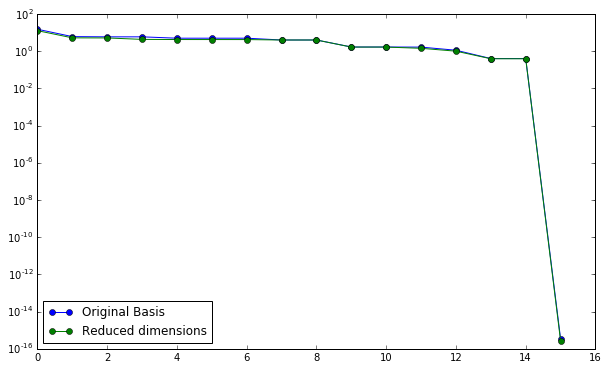

In [39]:
#New covariance matrix is Mp = A.T * A

Mp = np.dot(np.real(Ap.T),np.real(Ap))
Up,Sp,Vp = np.linalg.svd(Mp)

plt.semilogy(Sr,'o-',label='Original Basis')
plt.semilogy(Sp,'o-',label='Reduced dimensions')
plt.legend(loc=3)
plt.show()

# Gain variation

Gains are drawn from a power law distribution and noise goes down as poisson noise.

In [24]:
def gen_gains(a,gmin,gmax,N=1):
    return (gmin**(a+1)+(gmax**(a+1)- gmin**(a+1))*np.random.random(size=N))**(1/(a+1))

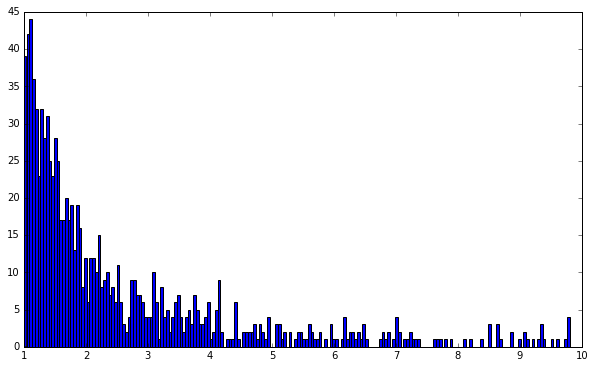

In [35]:
gains = gen_gains(-2,1,10,N=1000)
c,b,i = plt.hist(gains,bins=200)

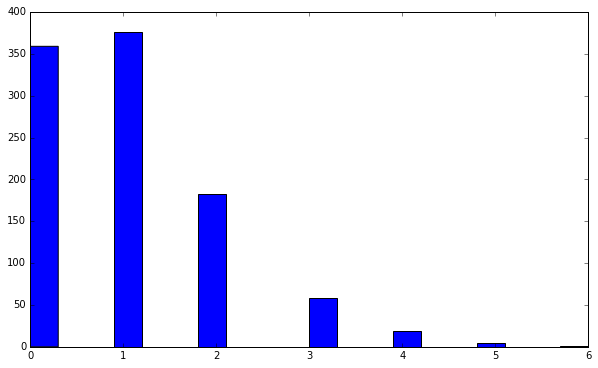

In [34]:
noise = np.random.poisson(1,1000)
c,b,i = plt.hist(noise,bins=20)

# Integration time

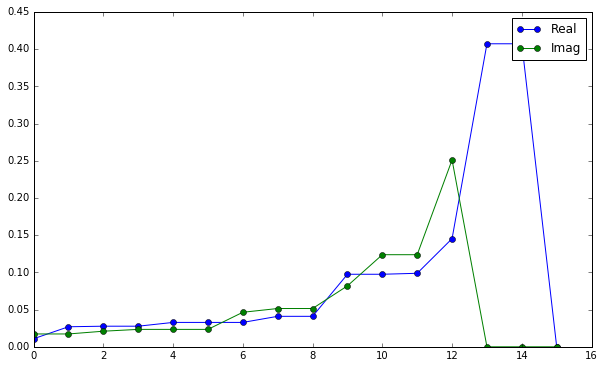

In [14]:
Tsys = 500
Tsrc = 5
B = 250e6/4096

Sr_inv = np.asarray([s**-1 if s>10**-11 else 0 for s in Sr])
Si_inv = np.asarray([s**-1 if s>10**-11 else 0 for s in Si])

tr = Tsys**2/(B*Tsrc**2)*Sr_inv
ti = Tsys**2/(B*Tsrc**2)*Si_inv

plt.plot(tr,'o-',label='Real')
plt.plot(ti,'o-',label='Imag')
plt.legend()
plt.show()

# Minimal inclusion

List of redundant baselines where every antenna is used only once.

**Minimal inclusion will not work because the number of cross correlations you compute is less that the number of equations you need to solve for any redundant pair you consider. **

In [6]:
def ant_in_bls(ant,baselines):
    bl = np.asarray([list(x) for x in baselines])
    if not np.size(bl):
        return False
    if ant in bl[:,0] or ant in bl[:,1]:
        return True
    else: return False
    
def build_minimal_cc(redbl_list):
    minimal_bl = []

    for i,j in redbl_list:
        if ant_in_bls(i,minimal_bl):
            continue
        if ant_in_bls(j,minimal_bl):
            continue
        else: minimal_bl.append((i,j))

    for i,j in redbl_list:
        if not ant_in_bls(i,minimal_bl) or not ant_in_bls(j,minimal_bl):
            minimal_bl.append((i,j))
            
    return minimal_bl

[(5, 0), (6, 1), (7, 2), (8, 3), (10, 4), (16, 9), (18, 11), (19, 12), (20, 13), (21, 14), (22, 15), (24, 17), (29, 23), (31, 25), (32, 26), (33, 28), (35, 30), (27, 20), (34, 29), (36, 31)]


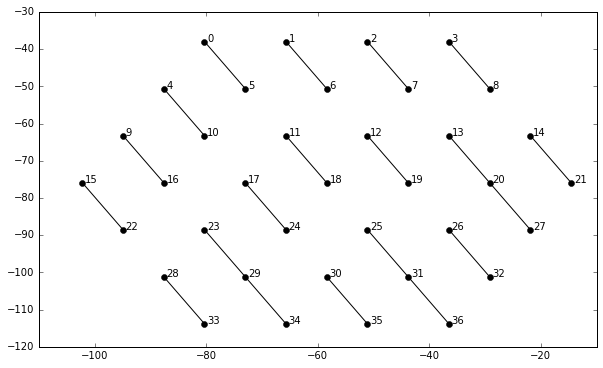

In [7]:
minbl = build_minimal_cc(redbls[0])
plot_redbl(minbl)
plot_ants(antpos)
print minbl